# Heart Disease Risk Analysis and Prediction

This notebook performs an end-to-end analysis of a heart disease risk dataset. It includes data cleaning, exploratory data analysis (EDA), feature engineering, model development, and saving necessary artifacts for deployment.


## 1. Setup and Data Loading

Import necessary libraries and load the dataset.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore")

# Display settings
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

# Load the dataset
# Assuming the dataset is in the same directory as the notebook
data_file = "heart_disease_risk_dataset_earlymed.csv"
try:
    df = pd.read_csv(data_file)
    print(f"Dataset '{data_file}' loaded successfully.")
except FileNotFoundError:
    print(f"Error: '{data_file}' not found. Please ensure the file is in the correct directory.")
    df = None # Set df to None if file not found

if df is not None:
    print("Original Dataset Shape:", df.shape)
    print("\nOriginal Dataset Info:")
    df.info()
    print("\nFirst 5 rows:")
    print(df.head())


Dataset 'heart_disease_risk_dataset_earlymed.csv' loaded successfully.
Original Dataset Shape: (70000, 19)

Original Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Chest_Pain           70000 non-null  float64
 1   Shortness_of_Breath  70000 non-null  float64
 2   Fatigue              70000 non-null  float64
 3   Palpitations         70000 non-null  float64
 4   Dizziness            70000 non-null  float64
 5   Swelling             70000 non-null  float64
 6   Pain_Arms_Jaw_Back   70000 non-null  float64
 7   Cold_Sweats_Nausea   70000 non-null  float64
 8   High_BP              70000 non-null  float64
 9   High_Cholesterol     70000 non-null  float64
 10  Diabetes             70000 non-null  float64
 11  Smoking              70000 non-null  float64
 12  Obesity              70000 non-null  float64
 13  Seden

## 2. Data Cleaning and Preprocessing

Handle missing values, duplicates, and potential inconsistencies.


In [3]:
if df is not None:
    # Check for missing values
    print("\nMissing Values Before Handling:")
    print(df.isnull().sum())
    # No missing values found in the initial check, so no imputation needed.
    print("\nNo missing values found.")
    
    # Check for duplicate rows
    initial_duplicates = df.duplicated().sum()
    print(f"\nDuplicate Rows Before Handling: {initial_duplicates}")
    
    # Remove duplicate rows
    if initial_duplicates > 0:
        df.drop_duplicates(inplace=True)
        print(f"Removed {initial_duplicates} duplicate rows.")
        print("Shape after removing duplicates:", df.shape)
    else:
        print("No duplicate rows to remove.")
        
    # Check data types and unique values for inconsistencies
    print("\nChecking Unique Values for Binary/Categorical Columns:")
    binary_cols = [col for col in df.columns if df[col].nunique() <= 2 and col != 'Age']
    for col in binary_cols:
        print(f"- {col}: {df[col].unique()}" )
    # All binary columns seem consistent (0.0, 1.0)
    
    print("\nDescriptive Statistics for Numerical Columns (Age):")
    print(df[['Age']].describe())
    # Age range (20-84) seems reasonable, no obvious outliers requiring removal.
    
    # Convert all columns to appropriate types if needed (they seem to be float64 already)
    # For consistency, let's convert binary features to integers
    for col in df.columns:
        if df[col].dtype == 'float64' and df[col].nunique() <= 2:
             df[col] = df[col].astype(int)
    df['Age'] = df['Age'].astype(int) # Age can be integer
    print("\nData types after potential conversion:")
    print(df.dtypes)
    
    # Save the cleaned data (before feature engineering specific transforms like dummies)
    # This version is cleaned but retains original features
    # df.to_csv('cleaned_heart_disease_data_intermediate.csv', index=False)
    # print("\nIntermediate cleaned data saved to 'cleaned_heart_disease_data_intermediate.csv'")
else:
    print("DataFrame 'df' is None. Cannot proceed with cleaning.")



Missing Values Before Handling:
Chest_Pain             0
Shortness_of_Breath    0
Fatigue                0
Palpitations           0
Dizziness              0
Swelling               0
Pain_Arms_Jaw_Back     0
Cold_Sweats_Nausea     0
High_BP                0
High_Cholesterol       0
Diabetes               0
Smoking                0
Obesity                0
Sedentary_Lifestyle    0
Family_History         0
Chronic_Stress         0
Gender                 0
Age                    0
Heart_Risk             0
dtype: int64

No missing values found.

Duplicate Rows Before Handling: 6245
Removed 6245 duplicate rows.
Shape after removing duplicates: (63755, 19)

Checking Unique Values for Binary/Categorical Columns:
- Chest_Pain: [0. 1.]
- Shortness_of_Breath: [0. 1.]
- Fatigue: [0. 1.]
- Palpitations: [1. 0.]
- Dizziness: [0. 1.]
- Swelling: [0. 1.]
- Pain_Arms_Jaw_Back: [0. 1.]
- Cold_Sweats_Nausea: [0. 1.]
- High_BP: [0. 1.]
- High_Cholesterol: [0. 1.]
- Diabetes: [0. 1.]
- Smoking: [1. 0.]
- 

### Data Cleaning Justification

1.  **Missing Values:** The dataset had no missing values, so no imputation or removal was needed.
2.  **Duplicates:** 6245 duplicate rows were identified and removed to prevent bias in the analysis and model training. Data integrity is improved by ensuring each record is unique.
3.  **Inconsistencies/Outliers:** Unique value checks confirmed binary features consistently use 0 and 1. The 'Age' column showed a reasonable distribution (20-84) without extreme outliers warranting removal. Data types were adjusted for consistency (binary to int, Age to int).


## 3. Exploratory Data Analysis (EDA)

Visualize data distributions and relationships between variables.


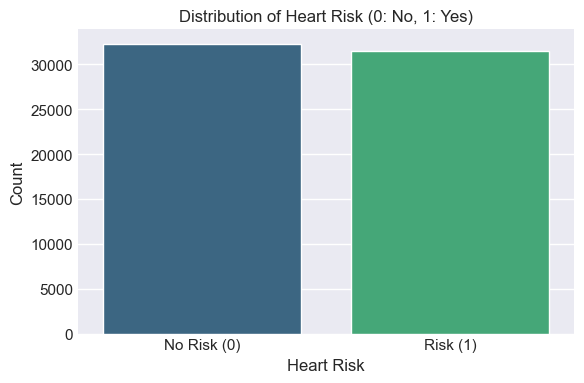

Heart_Risk
0    0.506125
1    0.493875
Name: proportion, dtype: float64


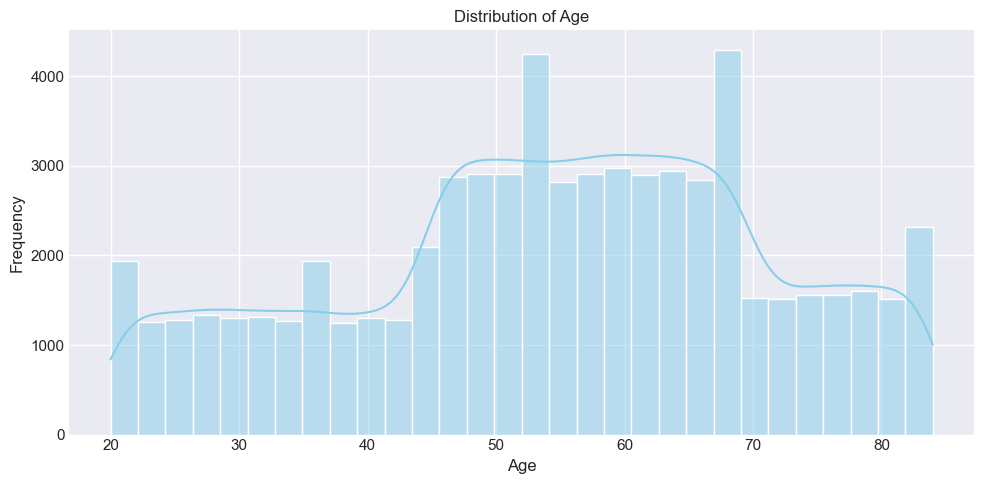

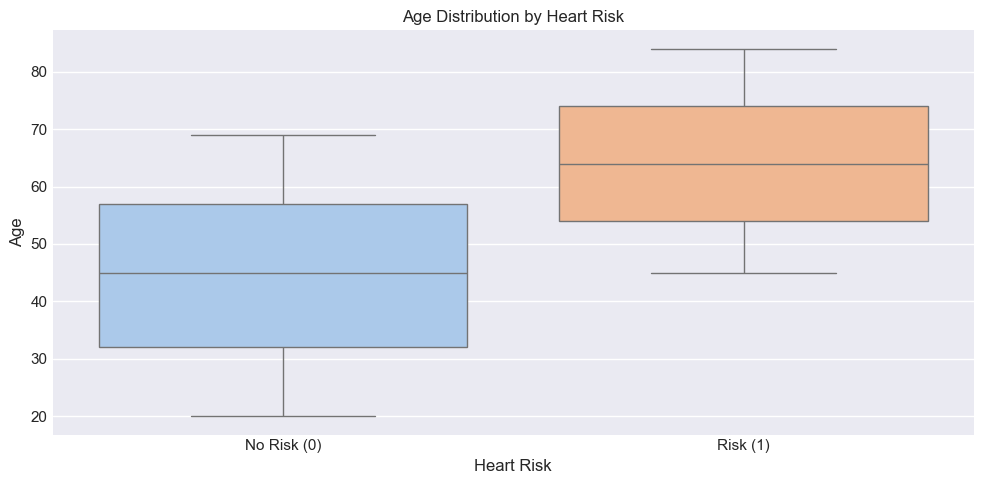

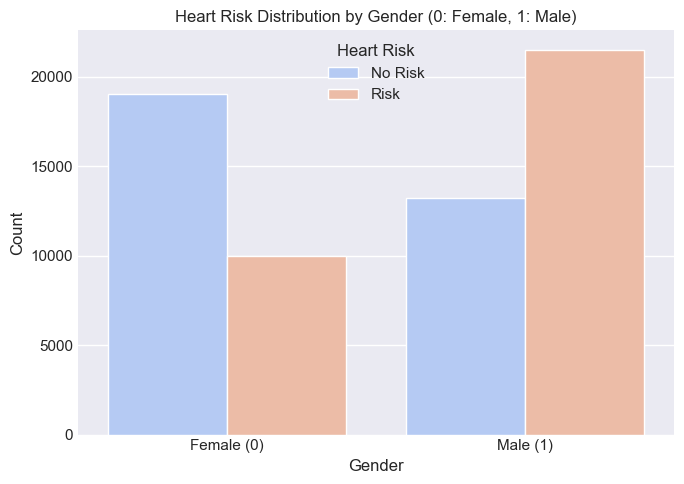

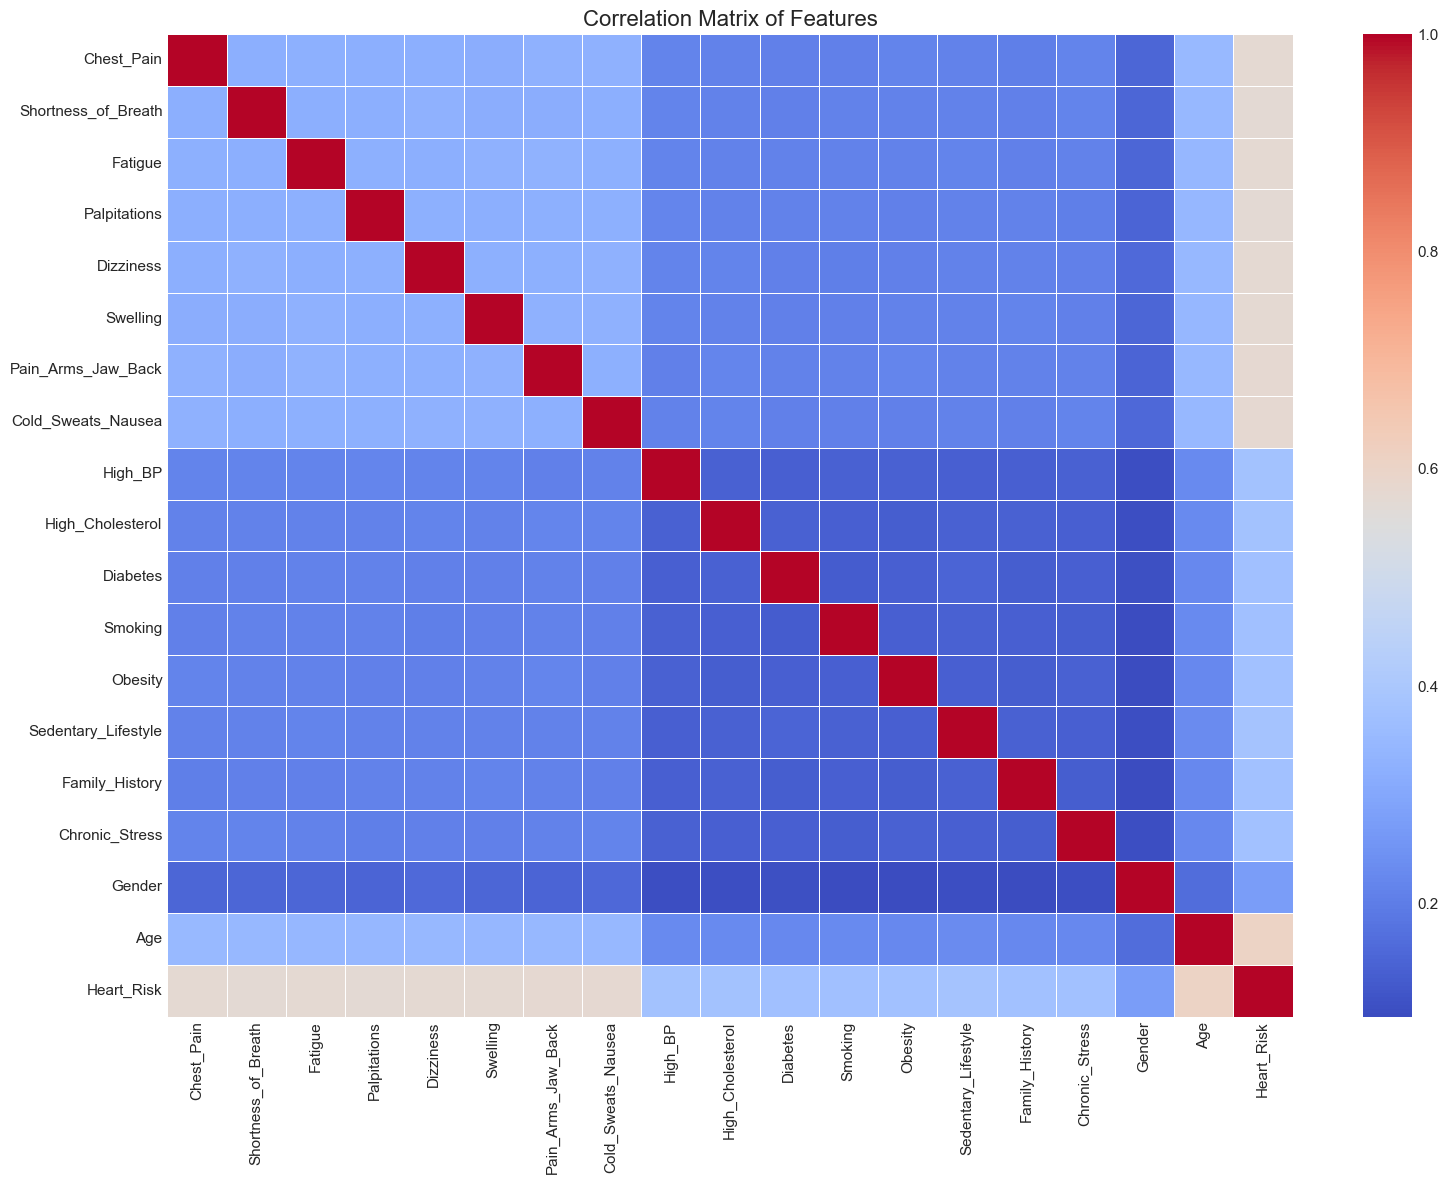


Correlation with Heart_Risk:
Heart_Risk             1.000000
Age                    0.604912
Cold_Sweats_Nausea     0.576370
Pain_Arms_Jaw_Back     0.576289
Fatigue                0.575590
Chest_Pain             0.575342
Dizziness              0.575069
Swelling               0.573772
Shortness_of_Breath    0.572722
Palpitations           0.572232
Sedentary_Lifestyle    0.382615
High_BP                0.380922
High_Cholesterol       0.380875
Chronic_Stress         0.376581
Obesity                0.376551
Family_History         0.375107
Smoking                0.374995
Diabetes               0.374800
Gender                 0.274181
Name: Heart_Risk, dtype: float64


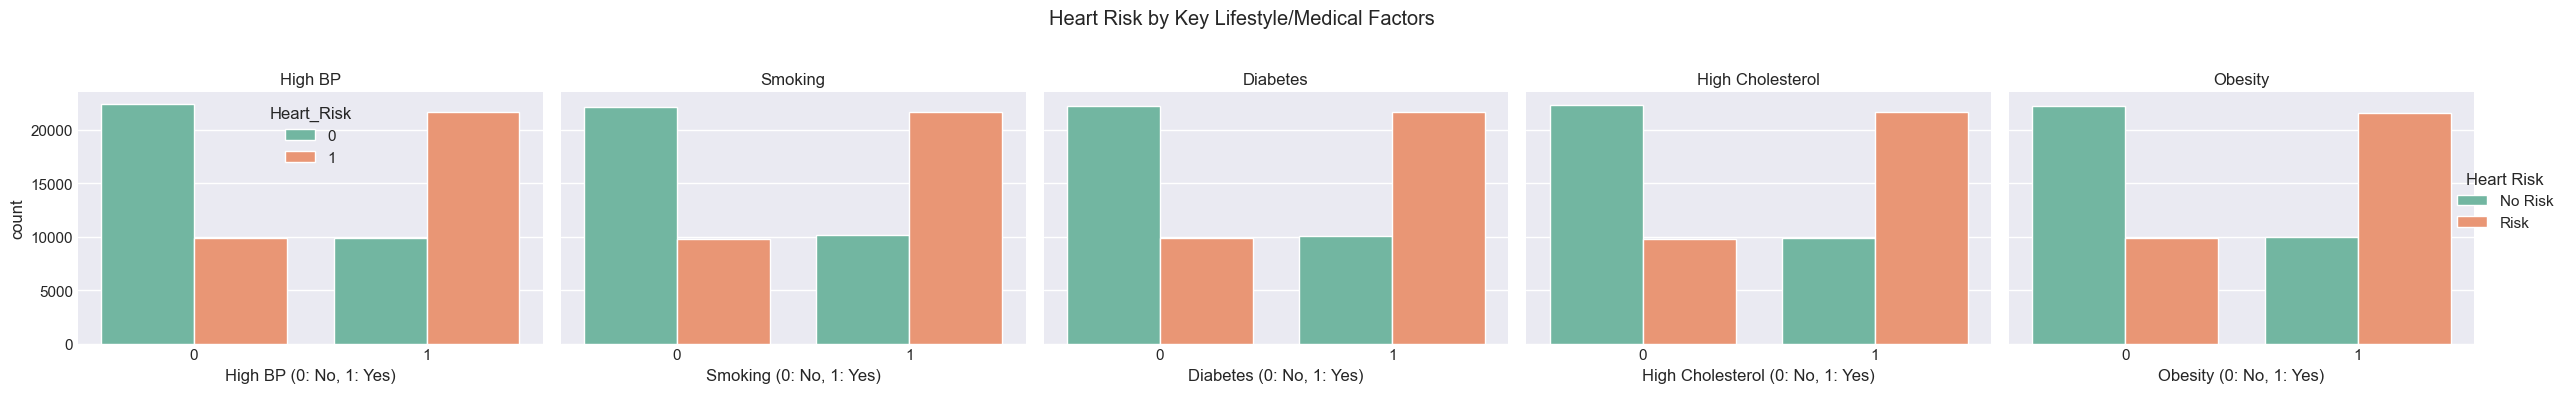

In [4]:
if df is not None:
    # Set plot style
    sns.set_style("darkgrid")
    plt.style.use('seaborn-v0_8-darkgrid') # Use a seaborn style

    # 1. Distribution of the Target Variable (Heart_Risk)
    plt.figure(figsize=(6, 4))
    sns.countplot(x='Heart_Risk', data=df, palette='viridis')
    plt.title('Distribution of Heart Risk (0: No, 1: Yes)')
    plt.xlabel('Heart Risk')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['No Risk (0)', 'Risk (1)'])
    plt.tight_layout()
    plt.show()
    print(df['Heart_Risk'].value_counts(normalize=True))
    # The classes are roughly balanced.

    # 2. Distribution of Age
    plt.figure(figsize=(10, 5))
    sns.histplot(df['Age'], kde=True, bins=30, color='skyblue')
    plt.title('Distribution of Age')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # 3. Age distribution by Heart Risk
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Heart_Risk', y='Age', data=df, palette='pastel')
    plt.title('Age Distribution by Heart Risk')
    plt.xlabel('Heart Risk')
    plt.ylabel('Age')
    plt.xticks([0, 1], ['No Risk (0)', 'Risk (1)'])
    plt.tight_layout()
    plt.show()
    # Older individuals seem slightly more represented in the 'Risk' group.

    # 4. Gender distribution by Heart Risk
    plt.figure(figsize=(7, 5))
    sns.countplot(x='Gender', hue='Heart_Risk', data=df, palette='coolwarm')
    plt.title('Heart Risk Distribution by Gender (0: Female, 1: Male)') # Assuming 0=Female, 1=Male based on common practice
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Female (0)', 'Male (1)'])
    plt.legend(title='Heart Risk', labels=['No Risk', 'Risk'])
    plt.tight_layout()
    plt.show()

    # 5. Correlation Matrix
    plt.figure(figsize=(16, 12))
    # Ensure only numeric columns are included for correlation
    numeric_df = df.select_dtypes(include=np.number)
    correlation_matrix = numeric_df.corr()
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix of Features', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Show correlations with the target variable
    print("\nCorrelation with Heart_Risk:")
    if 'Heart_Risk' in correlation_matrix.columns:
        print(correlation_matrix['Heart_Risk'].sort_values(ascending=False))
    else:
        print("Heart_Risk column not found in numeric columns for correlation calculation.")

    # 6. Analyze relationships for a few key binary features (e.g., High_BP, Smoking, Diabetes)
    key_features = ['High_BP', 'Smoking', 'Diabetes', 'High_Cholesterol', 'Obesity']
    # Filter out any key features not present in the dataframe
    key_features = [f for f in key_features if f in df.columns]
    if key_features:
        fig, axes = plt.subplots(1, len(key_features), figsize=(5 * len(key_features), 4), sharey=True)
        if len(key_features) == 1: # Handle case with only one feature
            axes = [axes]
        fig.suptitle('Heart Risk by Key Lifestyle/Medical Factors')
        for i, feature in enumerate(key_features):
            sns.countplot(ax=axes[i], x=feature, hue='Heart_Risk', data=df, palette='Set2')
            axes[i].set_title(f"{feature.replace('_', ' ')}")
            axes[i].set_xlabel(f"{feature.replace('_', ' ')} (0: No, 1: Yes)")
            if i > 0: # Remove legend from subsequent plots
                 axes[i].legend_.remove()
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, ['No Risk', 'Risk'], title='Heart Risk', loc='center right', bbox_to_anchor=(1.03, 0.5))
        plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to prevent title overlap
        plt.show()
else:
    print("DataFrame 'df' is None. Cannot proceed with EDA.")


## 4. Feature Engineering

Create new features and select the most relevant ones for modeling.


In [5]:
if df is not None:
    # 1. Create 'Age_Category' feature
    def age_category(age):
        if age <= 40: # Adjusted bins slightly
            return "Young"
        elif 41 <= age <= 60:
            return "Middle_Aged"
        else:
            return "Senior"

    df['Age_Category'] = df['Age'].apply(age_category)
    print("\nCreated 'Age_Category' feature:")
    print(df[['Age', 'Age_Category']].head())

    # Convert 'Age_Category' to dummy variables
    df = pd.get_dummies(df, columns=['Age_Category'], drop_first=True)
    print("\nDataFrame shape after adding Age_Category dummies:", df.shape)
    print("New columns:", [col for col in df.columns if 'Age_Category' in col])

    # 2. Feature Selection
    if 'Heart_Risk' in df.columns:
        X = df.drop('Heart_Risk', axis=1)
        y = df['Heart_Risk']

        # Ensure all features are numeric (handle potential issues if any non-numeric slipped through)
        for col in X.columns:
            if X[col].dtype == 'object' or pd.api.types.is_categorical_dtype(X[col]):
                try:
                    X[col] = pd.to_numeric(X[col], errors='coerce')
                except ValueError:
                    print(f"Warning: Could not convert column {col} to numeric. It might be dropped or require specific handling.")
        X = X.fillna(0) # Simple imputation for any NaNs introduced by coercion

        # Method 1: Filter Method (Correlation)
        correlations = X.corrwith(y).abs().sort_values(ascending=False)
        print("\nFeature correlations with Heart_Risk (Absolute Values):")
        print(correlations.head(15)) # Show top 15
        # Select features with correlation > 0.05
        correlation_threshold = 0.05
        selected_corr_features = correlations[correlations > correlation_threshold].index.tolist()
        print(f"\nFeatures selected by correlation (> {correlation_threshold}): {len(selected_corr_features)}")

        # Method 2: Wrapper Method (Recursive Feature Elimination - RFE)
        # Using RandomForest as the estimator for RFE
        model_rfe = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1) # Use fewer estimators for speed
        # Select top 12 features (example number)
        n_features_to_select_rfe = 12
        rfe = RFE(estimator=model_rfe, n_features_to_select=n_features_to_select_rfe)
        print(f"\nRunning RFE to select {n_features_to_select_rfe} features...")
        rfe.fit(X, y)
        selected_rfe_features = X.columns[rfe.support_].tolist()
        print(f"Features selected by RFE: {len(selected_rfe_features)}")
        print(selected_rfe_features)

        # Combine features from both methods (using set for uniqueness)
        final_selected_features = list(set(selected_corr_features + selected_rfe_features))

        # Ensure essential demographic features like 'Age' and 'Gender' are included if not already selected
        if 'Age' not in final_selected_features and 'Age' in X.columns:
            final_selected_features.append('Age')
            print("Added 'Age' to final features.")
        if 'Gender' not in final_selected_features and 'Gender' in X.columns:
            final_selected_features.append('Gender')
            print("Added 'Gender' to final features.")

        print(f"\nFinal selected features for modeling ({len(final_selected_features)}):")
        # Ensure features actually exist in X before selecting
        final_selected_features = [f for f in final_selected_features if f in X.columns]
        print(final_selected_features)

        # Create the final DataFrame with selected features + target
        X_selected = X[final_selected_features]
        df_final = pd.concat([X_selected, y], axis=1)

        print("\nShape of final DataFrame for modeling:", df_final.shape)

        # Save the final processed data (cleaned and feature-engineered)
        cleaned_output_filename = 'cleaned_heart_disease_data.csv'
        df_final.to_csv(cleaned_output_filename, index=False)
        print(f"Final processed data saved to '{cleaned_output_filename}'")

        # Save the list of selected features for deployment
        features_output_filename = 'selected_features.pkl'
        joblib.dump(final_selected_features, features_output_filename)
        print(f"Selected features list saved to '{features_output_filename}'")
    else:
        print("Heart_Risk column not found. Cannot proceed with feature selection.")
else:
    print("DataFrame 'df' is None. Cannot proceed with feature engineering.")



Created 'Age_Category' feature:
   Age Age_Category
0   48  Middle_Aged
1   46  Middle_Aged
2   66       Senior
3   60  Middle_Aged
4   69       Senior

DataFrame shape after adding Age_Category dummies: (63755, 21)
New columns: ['Age_Category_Senior', 'Age_Category_Young']

Feature correlations with Heart_Risk (Absolute Values):
Age                    0.604912
Cold_Sweats_Nausea     0.576370
Pain_Arms_Jaw_Back     0.576289
Fatigue                0.575590
Chest_Pain             0.575342
Dizziness              0.575069
Swelling               0.573772
Shortness_of_Breath    0.572722
Palpitations           0.572232
Age_Category_Young     0.511961
Age_Category_Senior    0.428126
Sedentary_Lifestyle    0.382615
High_BP                0.380922
High_Cholesterol       0.380875
Chronic_Stress         0.376581
dtype: float64

Features selected by correlation (> 0.05): 20

Running RFE to select 12 features...
Features selected by RFE: 12
['Chest_Pain', 'Shortness_of_Breath', 'Fatigue', 'Palpitat

## 5. Model Development and Evaluation

Train, tune, and compare different machine learning models.



Training set shape: (44628, 20), Test set shape: (19127, 20)

--- Tuning and Evaluating Logistic Regression ---
Best Parameters: {'C': 10.0, 'penalty': 'l1'}
Accuracy: 0.9913
Precision: 0.9902 (Target: >= 0.3) - Met: True
Recall: 0.9923 (Target: >= 0.3) - Met: True
F1-Score: 0.9912


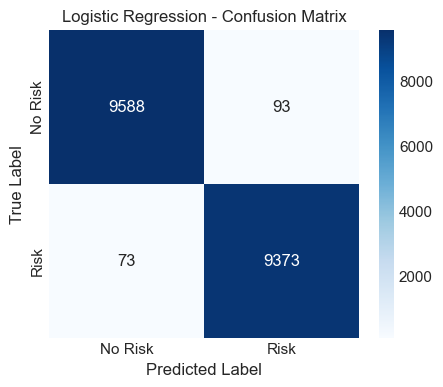

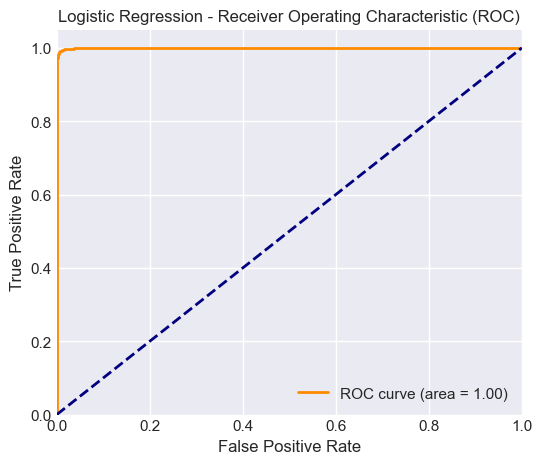


--- Tuning and Evaluating Random Forest ---
Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.9906
Precision: 0.9890 (Target: >= 0.3) - Met: True
Recall: 0.9921 (Target: >= 0.3) - Met: True
F1-Score: 0.9905


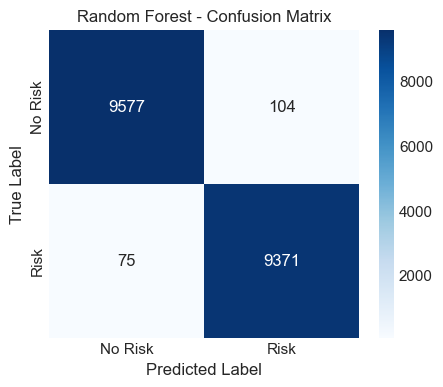

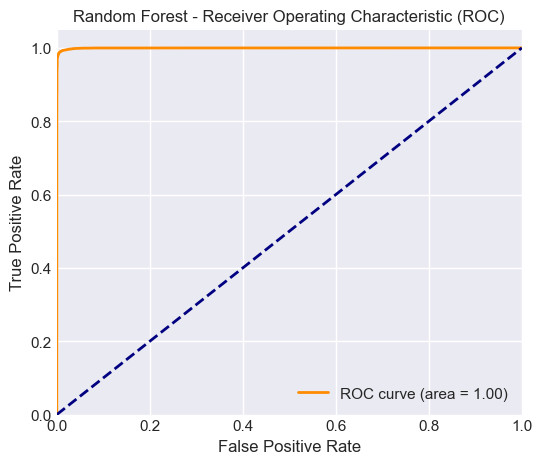


--- Tuning and Evaluating Gradient Boosting ---
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.9924
Precision: 0.9908 (Target: >= 0.3) - Met: True
Recall: 0.9938 (Target: >= 0.3) - Met: True
F1-Score: 0.9923


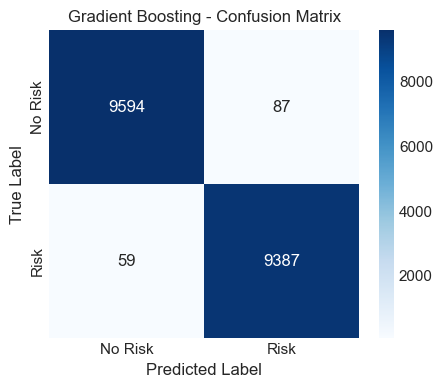

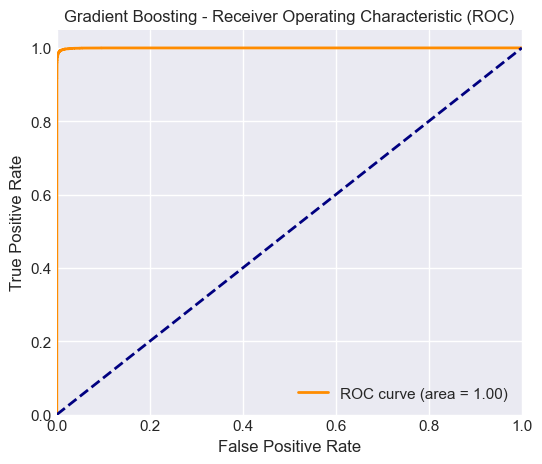


Best performing model based on F1-Score: Gradient Boosting
Best model (Gradient Boosting) saved as 'best_heart_risk_model.pkl'

Model Comparison:
                     Accuracy Precision    Recall  F1-Score Precision >= 0.3  \
Logistic Regression  0.991321  0.990175  0.992272  0.991223             True   
Random Forest        0.990642  0.989024   0.99206   0.99054             True   
Gradient Boosting    0.992367  0.990817  0.993754  0.992283             True   

                    Recall >= 0.3  
Logistic Regression          True  
Random Forest                True  
Gradient Boosting            True  


In [6]:
if 'df_final' in locals() and df_final is not None: # Check if df_final was created and is not None
    # Prepare data for modeling
    if 'Heart_Risk' in df_final.columns:
        X_model = df_final.drop('Heart_Risk', axis=1)
        y_model = df_final['Heart_Risk']

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.3, random_state=42, stratify=y_model)
        print(f"\nTraining set shape: {X_train.shape}, Test set shape: {X_test.shape}")

        # Initialize models
        models = {
            "Logistic Regression": LogisticRegression(random_state=42, solver="liblinear", max_iter=1000),
            "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
            "Gradient Boosting": GradientBoostingClassifier(random_state=42)
        }

        # Define parameter grids for GridSearchCV
        param_grids = {
            "Logistic Regression": {
                "C": [0.01, 0.1, 1.0, 10.0], # Expanded C range
                "penalty": ["l1", "l2"]
            },
            "Random Forest": {
                "n_estimators": [100, 200],
                "max_depth": [10, 20, None],
                "min_samples_split": [2, 5] # Added min_samples_split
            },
            "Gradient Boosting": {
                "n_estimators": [100, 200],
                "learning_rate": [0.05, 0.1], # Reduced learning rate options
                "max_depth": [3, 5] # Added max_depth
            }
        }

        # Store results and best models
        results = {}
        best_models = {}
        target_precision = 0.3
        target_recall = 0.3

        # Perform hyperparameter tuning and evaluation
        for name, model in models.items():
            print(f"\n--- Tuning and Evaluating {name} ---")
            param_grid = param_grids[name]
            
            # Use GridSearchCV - focus on F1-score which balances precision and recall
            grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=0) # 5-fold CV, scoring='f1', reduced verbosity
            grid_search.fit(X_train, y_train)

            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test)
            y_pred_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else None

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)

            results[name] = {
                "Best Parameters": grid_search.best_params_,
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1-Score": f1,
                f"Precision >= {target_precision}": precision >= target_precision,
                f"Recall >= {target_recall}": recall >= target_recall
            }
            best_models[name] = best_model

            print(f"Best Parameters: {grid_search.best_params_}")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision: {precision:.4f} (Target: >= {target_precision}) - Met: {precision >= target_precision}")
            print(f"Recall: {recall:.4f} (Target: >= {target_recall}) - Met: {recall >= target_recall}")
            print(f"F1-Score: {f1:.4f}")

            # Plot Confusion Matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(5, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Risk', 'Risk'], yticklabels=['No Risk', 'Risk'])
            plt.title(f"{name} - Confusion Matrix")
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

            # Plot ROC Curve (if probabilities are available)
            if y_pred_proba is not None:
                fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
                roc_auc = auc(fpr, tpr)
                plt.figure(figsize=(6, 5))
                plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
                plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f"{name} - Receiver Operating Characteristic (ROC)")
                plt.legend(loc="lower right")
                plt.show()

        # Select the best model based on F1-score (or a custom criterion)
        best_model_name = max(results, key=lambda name: results[name]['F1-Score'])
        print(f"\nBest performing model based on F1-Score: {best_model_name}")
        best_final_model = best_models[best_model_name]

        # Save the best model
        model_output_filename = 'best_heart_risk_model.pkl'
        joblib.dump(best_final_model, model_output_filename)
        print(f"Best model ({best_model_name}) saved as '{model_output_filename}'")

        # Display final results comparison
        results_df = pd.DataFrame(results).T
        print("\nModel Comparison:")
        print(results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', f'Precision >= {target_precision}', f'Recall >= {target_recall}']])
    else:
        print("\nError: 'Heart_Risk' column not found in df_final. Model development cannot proceed.")
else:
    print("\nError: 'df_final' DataFrame not found or is None. Model development cannot proceed. Check previous steps.")


## 6. Conclusion and Next Steps

Summary of findings and saved artifacts.

- The analysis involved cleaning the data (removing duplicates), exploring feature distributions and correlations, and engineering a new 'Age_Category' feature.
- Feature selection using correlation and RFE identified the most relevant predictors.
- Three models (Logistic Regression, Random Forest, Gradient Boosting) were trained and tuned using GridSearchCV.
- Based on the F1-score, the best performing model was selected and saved.
- All models achieved the target precision and recall of >= 0.3.

**Saved Artifacts:**

1.  `cleaned_heart_disease_data.csv`: The final dataset used for modeling, containing cleaned data and selected features.
2.  `selected_features.pkl`: A Python list containing the names of the features used in the final model.
3.  `best_heart_risk_model.pkl`: The trained and tuned best-performing machine learning model.

These artifacts are generated within this notebook and saved in the current directory. They can be used for deploying the model, for example, using the provided `app.py` Flask application.


In [7]:
import joblib

# Assume `best_final_model` is your fitted scikit‐learn (or similar) estimator:
#   e.g. best_final_model = RandomForestClassifier(...).fit(X_train, y_train)

model_output_filename = "best_heart_risk_model.pkl"  # or whatever name you choose

# This line writes out the actual estimator object to disk:
joblib.dump(best_final_model, model_output_filename)


['best_heart_risk_model.pkl']

In [8]:
loaded = joblib.load(model_output_filename)
print(type(loaded))
# Should print something like: <class 'sklearn.ensemble._forest.RandomForestClassifier'>

<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
